<a href="https://colab.research.google.com/github/ffelicioni/conv3d_video/blob/main/clasificar_hands_one_leave_pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Clasificación de lenguaje de señas

## Módulos

In [1]:
import os as os
import pandas as pd
import glob
from pathlib import Path

from IPython.display import clear_output
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as math

from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow import keras

import cv2

from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from skimage import io

import random as random

import shutil

## Funciones

In [2]:
! mkdir /content/src
sys.path.append('./src')
% cd /content/src
archivos=['__init__.py','armado_dataset.py','clasificacion.py','visualizar_filtros.py','carga_datos.py','separar_train_test.py']
for archivo in archivos:
    !wget "https://raw.githubusercontent.com/ffelicioni/conv3d_video/main/src/{archivo}"
% cd /content

clear_output()

In [3]:
from armado_dataset import video_capturing_function, data_load_function_frames, resampling_rand, data_load_frames_save_tf, load_data_from_tf, df_videos_names, video_duracion
from separar_train_test import df_train_reordenar
from clasificacion import prob2labels, accuracy, confusion
from visualizar_filtros import plot_conv_weight, layer_by_name

Clase sequence para carga de datos

In [4]:
class CustomSequence(keras.utils.Sequence):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.n=3868
    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, batch_index):
        idx_start = batch_index*self.batch_size
        idx_end = idx_start+self.batch_size
        
        X=load_data_from_tf(df_train_batch[idx_start:idx_end],"train_data")
        #print(df_train_batch[idx_start:idx_end])
        a=np.array(df_train_batch[idx_start:idx_end].ID)
        y = tf.keras.utils.to_categorical(a-1, num_classes =64)
        
        nf,w,h=X[0].shape
        X.reshape(self.batch_size,nf,w,h,1)
        return X, y

## Chequeo GPU

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
!/opt/bin/nvidia-smi

Fri Jul 15 21:51:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |    284MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import gc
gc.collect()

366

## Datasets

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
!unzip drive/MyDrive/lsa64_preprocessed.zip -d dataset
clear_output()

Armo dataset con nombres de los videos disponibles

In [11]:
df=df_videos_names('/content/dataset/lsa64_hand_videos/*.avi')
print('cantidad de videos:',len(sorted(glob.glob('/content/dataset/lsa64_hand_videos/*.avi'))))
print('cantidad de videos de la mano derecha:',len(df[df.mano=='right']))
print('cantidad de videos de la mano izquierda:',len(df[df.mano=='left']))
print('cantidad de personas:', len(df.persona.unique()))
print('cantidad de repeticiones:', len(df.repeticion.unique()))

cantidad de videos: 4299
cantidad de videos de la mano derecha: 3200
cantidad de videos de la mano izquierda: 1099
cantidad de personas: 10
cantidad de repeticiones: 5


In [12]:
clases=pd.read_csv('https://raw.githubusercontent.com/ffelicioni/conv3d_video/main/data/clase_LSA64.csv')
print('cantidad de clases:', len(clases.Name.unique()),'nombres: ',clases.Name.unique())

cantidad de clases: 64 nombres:  ['Opaque' 'Red' 'Green' 'Yellow' 'Bright' 'Light-blue' 'Colors' 'Rose'
 'Women' 'Enemy' 'Son' 'Man' 'Away' 'Drawer' 'Born' 'Learn' 'Call'
 'Skimmer' 'Bitter' 'Sweet milk' 'Milk' 'Water' 'Food' 'Argentina'
 'Uruguay' 'Country' 'Last name' 'Where' 'Mock' 'Birthday' 'Breakfast'
 'Photo' 'Hungry' 'Map' 'Coin' 'Music' 'Ship' 'None' 'Name' 'Patience'
 'Perfume' 'Deaf' 'Trap' 'Rice' 'Barbecue' 'Candy' 'Chewing-gum'
 'Spaghetti' 'Yogurt' 'Accept' 'Thanks' 'Shut down' 'Appear' 'To land'
 'Catch' 'Help' 'Dance' 'Bathe' 'Buy' 'Copy' 'Run' 'Realize' 'Give' 'Find']


In [13]:
df['id_name']=pd.merge(df,clases,on='ID',how='left').Name
df

,file_path,ID,persona,repeticion,mano,id_name
0,/content/dataset/lsa64_hand_videos/001_001_001...,1,001,001,right,Opaque
1,/content/dataset/lsa64_hand_videos/001_001_002...,1,001,002,right,Opaque
2,/content/dataset/lsa64_hand_videos/001_001_003...,1,001,003,right,Opaque
3,/content/dataset/lsa64_hand_videos/001_001_004...,1,001,004,right,Opaque
4,/content/dataset/lsa64_hand_videos/001_001_005...,1,001,005,right,Opaque
...,...,...,...,...,...,...
4294,/content/dataset/lsa64_hand_videos/064_010_001...,64,010,001,right,Find
4295,/content/dataset/lsa64_hand_videos/064_010_002...,64,010,002,right,Find
4296,/content/dataset/lsa64_hand_videos/064_010_003...,64,010,003,right,Find
4297,/content/dataset/lsa64_hand_videos/064_010_004...,64,010,004,right,Find


Señas con cada mano

In [14]:
df[df.mano=='right']

,file_path,ID,persona,repeticion,mano,id_name
0,/content/dataset/lsa64_hand_videos/001_001_001...,1,001,001,right,Opaque
1,/content/dataset/lsa64_hand_videos/001_001_002...,1,001,002,right,Opaque
2,/content/dataset/lsa64_hand_videos/001_001_003...,1,001,003,right,Opaque
3,/content/dataset/lsa64_hand_videos/001_001_004...,1,001,004,right,Opaque
4,/content/dataset/lsa64_hand_videos/001_001_005...,1,001,005,right,Opaque
...,...,...,...,...,...,...
4294,/content/dataset/lsa64_hand_videos/064_010_001...,64,010,001,right,Find
4295,/content/dataset/lsa64_hand_videos/064_010_002...,64,010,002,right,Find
4296,/content/dataset/lsa64_hand_videos/064_010_003...,64,010,003,right,Find
4297,/content/dataset/lsa64_hand_videos/064_010_004...,64,010,004,right,Find


In [15]:
df[df.mano=='left'].ID.value_counts()

29    50
31    50
61    50
60    50
58    50
57    50
56    50
55    50
53    50
51    50
50    50
49    50
48    50
45    50
44    50
43    50
36    50
35    50
34    50
32    50
63    50
54    49
Name: ID, dtype: int64

Diferentes formas de separar en train y test
- selecciono datos de test en los cuales haya videos mezclados de distintos participantes
- selecciono datos de test de un único participante 

In [16]:
#df_right=df[df.mano=='right']

#_, X_test_index, _, _ = train_test_split(df_right.index, df_right.ID, stratify=df_right.ID, test_size=260,random_state=0)

#df_test=df_right.loc[sorted(X_test_index)]

In [17]:
#df_uno=pd.merge(df_test,df,on=['ID','persona','repeticion'],how='left')
#df_uno=df_uno[['file_path_y','ID','persona','repeticion','mano_y','id_name_y']]
#df_uno.rename(columns={'file_path_y':'file_path','mano_y':'mano','id_name_y':'id_name'},inplace=True)
#df_uno[df_uno.mano=='left']
#df_test=df_uno.copy()

Reservo al participante 10 para test

In [18]:
df_test=df[df.persona=='005']

In [19]:
df_train=df[~df.file_path.isin(df_test.file_path)]

In [20]:
print('tamaño dataset train', len(df_train))
print('tamaño dataset test', len(df_test))

tamaño dataset train 3870
tamaño dataset test 429


In [21]:
3870/4

967.5

In [22]:
3948/4

987.0

Lotes de 4

In [23]:
batch=967#len(df_train)//4
batch_size=4
cant_train=batch*batch_size 
n_test=len(df_test)
print('entrenamiento:',cant_train, 'testing:', n_test,'-', (len(df)-cant_train)/cant_train,'%')
print('cantidad batch:',batch,'batch_size:', cant_train / batch)

entrenamiento: 3868 testing: 429 - 0.11142709410548086 %
cantidad batch: 967 batch_size: 4.0


In [24]:
#X_train_index, X_test_index, y_train, y_test = train_test_split(df.index, df.ID, stratify=df.ID, test_size=n_test,random_state=0)
#df_train=df.loc[sorted(X_train_index)]
#df_test=df.loc[sorted(X_test_index)]
#df_train_batch=df_train_reordenar(df_train,cant_train,batch)

Mezclo los nombres de archivos en el conjuntos de train que será usado en entrenamiento CustomSequence. 

In [25]:
df_train_batch=df_train_reordenar(df_train,cant_train,batch)

In [26]:
#df_train_batch

In [27]:
#df_train_batch=df_train_batch.sample(frac=1, random_state=1)

In [28]:
df_train_batch[0:25]

,file_path,ID,persona,repeticion,mano,id_name
593,/content/dataset/lsa64_hand_videos/012_009_004...,12,009,004,right,Man
596,/content/dataset/lsa64_hand_videos/012_010_002...,12,010,002,right,Man
1497,/content/dataset/lsa64_hand_videos/029_010_004...,29,010,004,right,Mock
1939,/content/dataset/lsa64_hand_videos/035_004_005...,35,004,005,right,Coin
569,/content/dataset/lsa64_hand_videos/012_004_005...,12,004,005,right,Man
693,/content/dataset/lsa64_hand_videos/014_009_004...,14,009,004,right,Drawer
1340,/content/dataset/lsa64_hand_videos/027_009_001...,27,009,001,right,Last name
1917,/content/dataset/lsa64_hand_videos/035_002_004...,35,002,004,right,Coin
333,/content/dataset/lsa64_hand_videos/007_007_004...,7,007,004,right,Colors
515,/content/dataset/lsa64_hand_videos/011_004_001...,11,004,001,right,Son


Ejemplo de seña realizada con ambas manos en el conjunto de train

In [29]:
df_train_batch[((df_train_batch.ID==31)&(df_train_batch.persona=='009')&(df_train_batch.repeticion=='005'))]

,file_path,ID,persona,repeticion,mano,id_name
1639,/content/dataset/lsa64_hand_videos/031_009_005...,31,009,005,right,Breakfast
1638,/content/dataset/lsa64_hand_videos/031_009_005...,31,009,005,left,Breakfast


In [30]:
%ls

dataset/  drive/  sample_data/  src/


# Data training - test

Con la separación realizada se arman dos carpetas: train_data y test_data. Cada video fue convertido a un conjunto de imágenes de 1 solo canal, dentro de cada archivo.

Referencia 
https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77

In [31]:
video_capturing_function(df_train,'train_data')

video_capturing_function(df_test,'test_data')

All frames written in the: train_data Folder
All frames written in the: test_data Folder


In [32]:
gc.collect()

353

### Obtención de tensores 

**Funcion "data_load_frames_save_tf"**

Proceso los videos y selecciono 32 frames del total de videos de forma aleatoria, en caso que los videos tengan menos frames repito el último hasta completar los 32.

Los frames de cada video (imágenes) se pasan a tensores de numpy para que cuando se desee cargar lotes no se tenga que procesar imagenes sino leer archivos numpy previamente salvados. Los tensores son grabados en float32 para reducir el tamaño de archivos.

La función borra además las imágenes para no sobrecargar el disco de la máqunia del colab.

Los archivos de los tensores de numpy se guardan en **train_data** y **test_data**

In [33]:
data_load_frames_save_tf(df_test,'test_data',32)
data_load_frames_save_tf(df_train,'train_data',32)

In [34]:
gc.collect()

50

# Modelo Convolucional 3D 


In [35]:
test_dataset_new=load_data_from_tf(df_test,"test_data")

In [36]:
test_dataset_new.shape

(429, 32, 128, 128)

In [37]:
a=np.array(df_test.ID)
y_test = tf.keras.utils.to_categorical(a-1, num_classes =np.max(df_test.ID))

model_output_size=len(df_test.ID.unique())
model_output_size

64

Conv2D(stride_temporal=2)->
Conv2D(stride_temporal=2,stride_espacial=2) -> Conv2D(stride_temporal=2) -> Conv2D(stride_temporal=2,stride_espacial=2)

In [39]:
nf=32
w=128 
h=128

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

def create_model():

    model = Sequential()

    #model.add(Conv3D(filters = 32, kernel_size = (3, 3,3), strides=(2,1,1), padding='same', activation = 'relu', input_shape = (nf,w, h, 1)))
    model.add(Conv3D(filters = 32, kernel_size = (3, 3,3), strides=(1,1,1), padding='same', activation = 'relu', input_shape = (nf,w, h, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2, 2,2)))
    
    #model.add(Conv3D(filters = 32, kernel_size = (3, 3,3),strides=(2,2,2), padding='same', activation = 'relu'))
    model.add(Conv3D(filters = 32, kernel_size = (3, 3,3),strides=(1,1,1), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2, 2,2)))

    #model.add(Conv3D(filters = 32, kernel_size = (3, 3,3),strides=(2,1,1), padding='same', activation = 'relu'))
    model.add(Conv3D(filters = 32, kernel_size = (3, 3,3),strides=(1,1,1), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2, 2,2)))

    #model.add(Conv3D(filters = 64, kernel_size = (3, 3,3),strides=(2,2,2), padding='same', activation = 'relu'))
    model.add(Conv3D(filters = 64, kernel_size = (3, 3,3),strides=(1,1,1), padding='same', activation = 'relu')) 
    
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2, 2,2)))
    model.add(GlobalAveragePooling3D())

    model.add(Dense(model_output_size, activation = 'softmax'))

    model.summary()

    return model


model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 128, 128, 32)  896       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 128, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 16, 64, 64, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 64, 64, 32)    27680     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 64, 32)   128       
 hNormalization)                                                 
                                                        

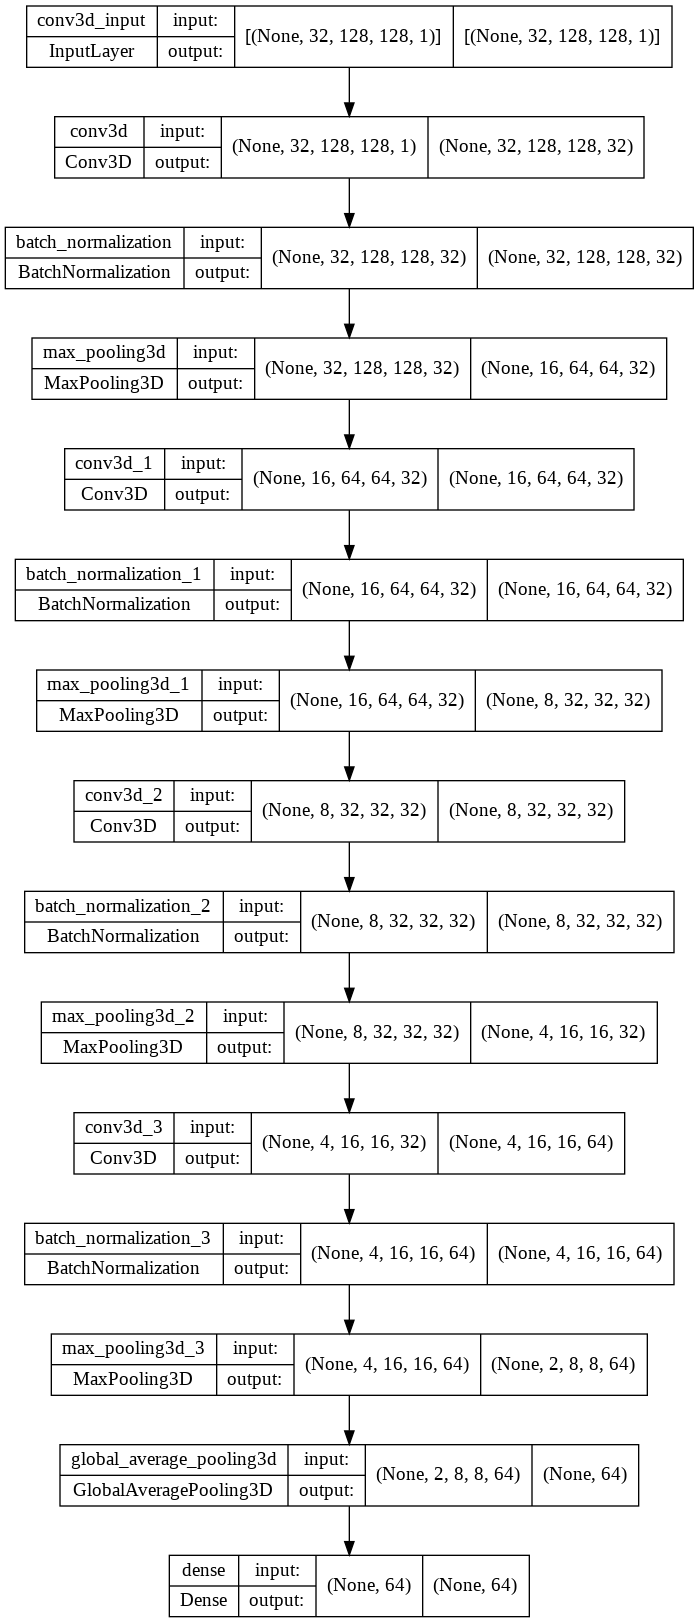

In [40]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

### Entrenamiento con Custom Sequence 

La función CustomSequence carga cada lote con 128 tensores numpy guardados en la carpeta train_data (nombre de archivo.npy) usando la función 
**load_data_from_tf**. 

In [41]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ["accuracy"])

model_training_history = model.fit(CustomSequence(4), epochs=40 , validation_data=(test_dataset_new,y_test), callbacks = [early_stopping_callback]) #, shuffle = True

Epoch 1/40
967/967 [==============================] - 96s 87ms/step - loss: 3.6513 - accuracy: 0.0918 - val_loss: 3.2608 - val_accuracy: 0.1492
Epoch 2/40
967/967 [==============================] - 82s 85ms/step - loss: 2.8760 - accuracy: 0.2526 - val_loss: 2.7649 - val_accuracy: 0.2238
Epoch 3/40
967/967 [==============================] - 83s 86ms/step - loss: 2.2120 - accuracy: 0.4224 - val_loss: 2.6209 - val_accuracy: 0.2751
Epoch 4/40
967/967 [==============================] - 83s 86ms/step - loss: 1.6493 - accuracy: 0.5866 - val_loss: 1.5836 - val_accuracy: 0.5664
Epoch 5/40
967/967 [==============================] - 83s 86ms/step - loss: 1.1773 - accuracy: 0.7141 - val_loss: 1.7236 - val_accuracy: 0.5338
Epoch 6/40
967/967 [==============================] - 83s 86ms/step - loss: 0.8333 - accuracy: 0.8004 - val_loss: 1.0926 - val_accuracy: 0.6946
Epoch 7/40
967/967 [==============================] - 83s 86ms/step - loss: 0.5841 - accuracy: 0.8640 - val_loss: 1.6347 - val_accuracy:

In [42]:
print("Saving trained model..")
model.save('conv3d_lsa64.h5')
print("Done.")

Saving trained model..
Done.


In [43]:
y_predict=model.predict(test_dataset_new)
y_pred=prob2labels(y_predict)
accuracy(np.array(df_test.ID)-1,y_pred)

0.8787878787878788

In [44]:
confusion_calculada=confusion(np.array(df_test.ID)-1,y_pred).astype(int)
names=df.id_name.unique()

plt.figure(figsize=(17,14))
import seaborn as sns
confusion_normalizada=confusion_calculada / confusion_calculada.astype(np.float64).sum(axis=1)


<Figure size 1224x1008 with 0 Axes>

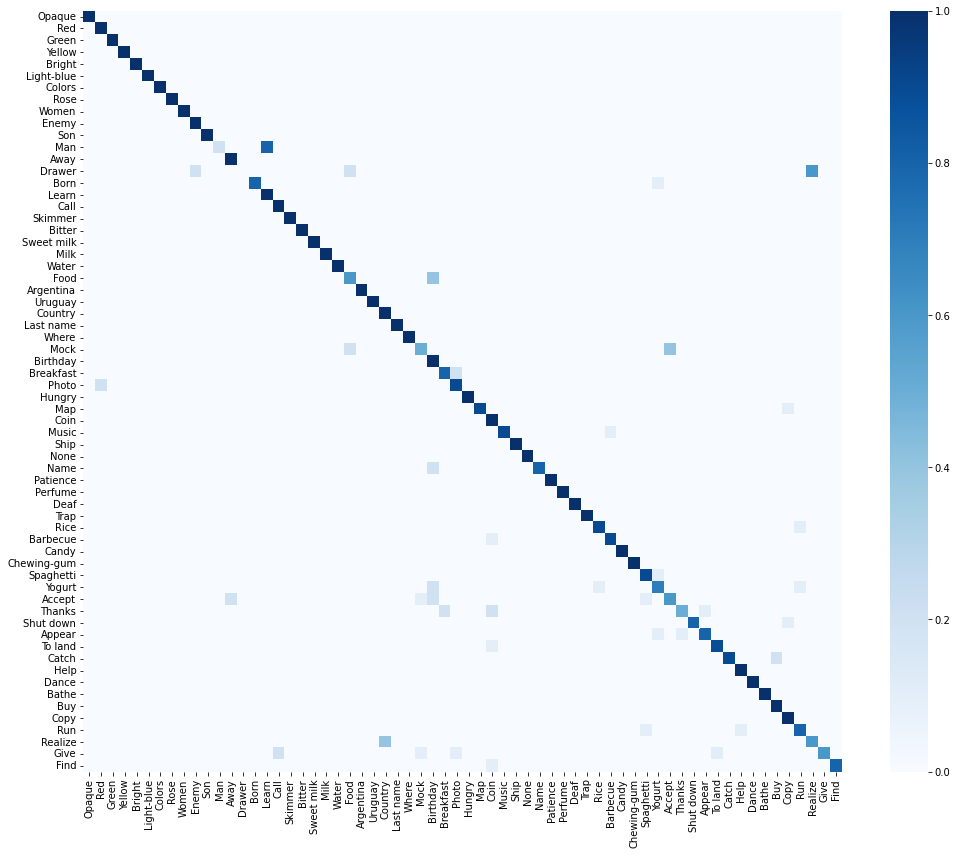

In [45]:
plt.figure(figsize=(17,14))
nombres=['Opaque','Red','Green','Yellow','Bright','Light-blue','Colors','Rose',
 'Women', 'Enemy', 'Son' ,'Man', 'Away', 'Drawer' ,'Born' ,'Learn', 'Call',
 'Skimmer', 'Bitter' ,'Sweet milk' ,'Milk' ,'Water', 'Food', 'Argentina',
 'Uruguay' ,'Country', 'Last name', 'Where', 'Mock', 'Birthday', 'Breakfast',
 'Photo', 'Hungry' ,'Map' ,'Coin' ,'Music', 'Ship' ,'None' ,'Name' ,'Patience',
 'Perfume' ,'Deaf', 'Trap' ,'Rice' ,'Barbecue', 'Candy', 'Chewing-gum',
 'Spaghetti' ,'Yogurt' ,'Accept' ,'Thanks' ,'Shut down', 'Appear' ,'To land',
 'Catch', 'Help', 'Dance' ,'Bathe', 'Buy' ,'Copy', 'Run' ,'Realize','Give', 'Find']
df_confusion = pd.DataFrame(confusion_normalizada, index=nombres, columns=nombres)

sns.heatmap(df_confusion, cmap="Blues")

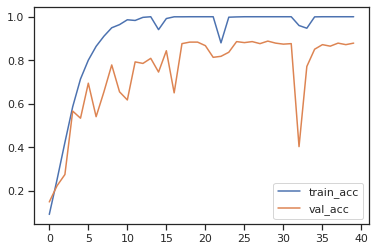

In [46]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.set_style("ticks")
plt.plot(model_training_history.history['accuracy'])
plt.plot(model_training_history.history['val_accuracy'])
sns.set_style("ticks")
plt.legend(['train_acc','val_acc'])

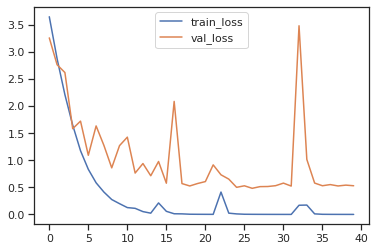

In [47]:
plt.plot(model_training_history.history['loss'])
plt.plot(model_training_history.history['val_loss'])
sns.set_style("ticks")
plt.legend(['train_loss','val_loss'])

Visualización de filtros del modelo

In [48]:
for layer in model.layers:
    if 'conv'  in layer.name.lower():
      filters, biases = layer.get_weights()
      print(layer.name,filters.shape)
    else:
      weights = layer.get_weights()
      if len(weights)>0:
        message = ",".join([str(w.shape) for w in weights])
      else:
        message="none"
      print(f"{layer.name} weights: {message}")


conv3d (3, 3, 3, 1, 32)
batch_normalization weights: (32,),(32,),(32,),(32,)
max_pooling3d weights: none
conv3d_1 (3, 3, 3, 32, 32)
batch_normalization_1 weights: (32,),(32,),(32,),(32,)
max_pooling3d_1 weights: none
conv3d_2 (3, 3, 3, 32, 32)
batch_normalization_2 weights: (32,),(32,),(32,),(32,)
max_pooling3d_2 weights: none
conv3d_3 (3, 3, 3, 32, 64)
batch_normalization_3 weights: (64,),(64,),(64,),(64,)
max_pooling3d_3 weights: none
global_average_pooling3d weights: none
dense weights: (64, 64),(64,)


filters - primera capa - 0 a 8


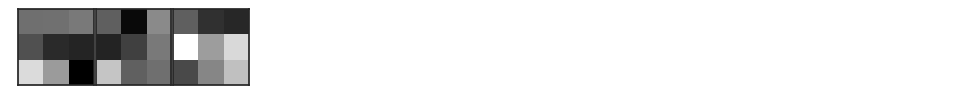

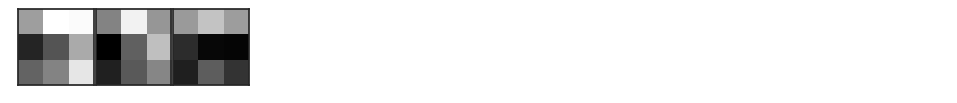

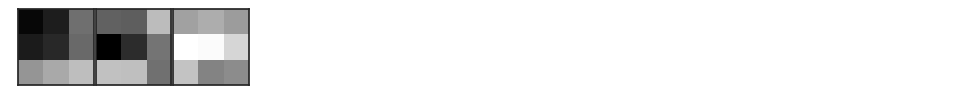

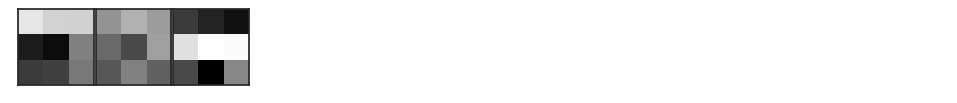

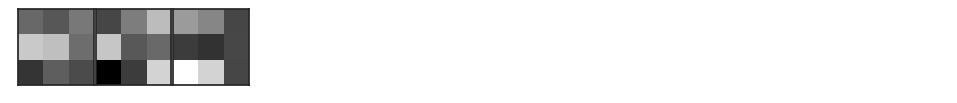

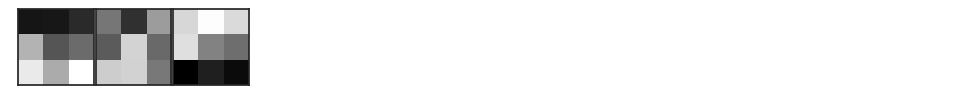

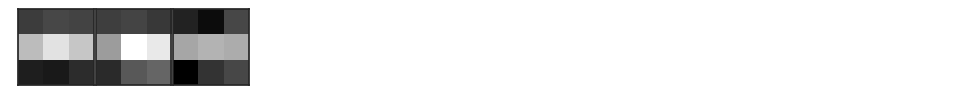

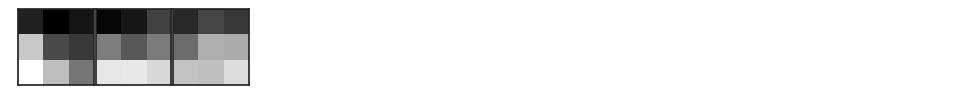

In [49]:
#Elegir capa convolucional y nro de filtro
layer_name="conv3d"
filter_index=0

layer = layer_by_name(model,layer_name)
filters, biases = layer.get_weights()

#filters.shape[4]//4

print('filters - primera capa - 0 a 8')
# 8 primeros filtros de la primera capa convolucional
for i in range(0,8): 
  plot_conv_weight(layer.name,filters[:,:,:,0,i])

filters - primera capa - 8 a 16


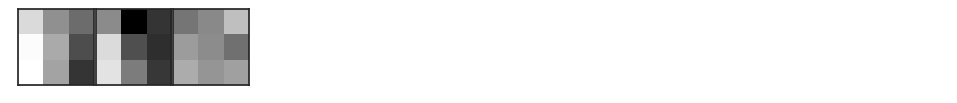

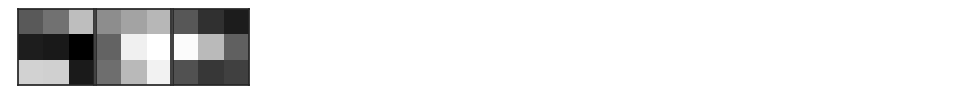

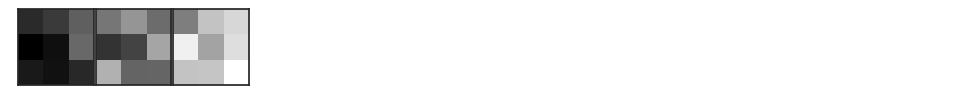

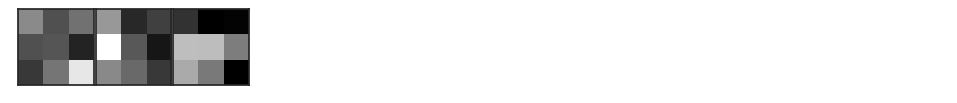

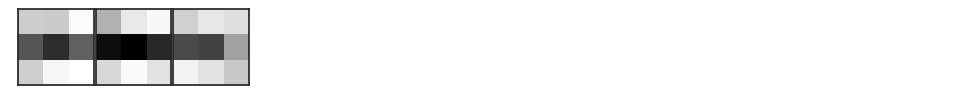

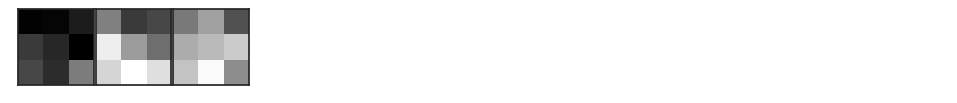

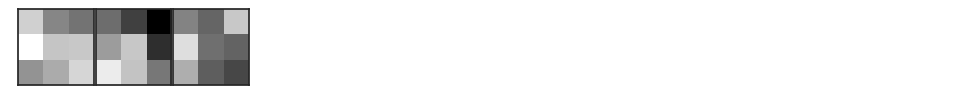

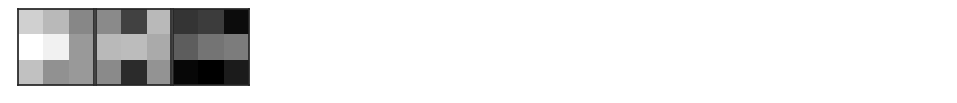

In [50]:
print('filters - primera capa - 8 a 16')
# 8 segundos filtros de la primera capa convolucional
for i in range(8,16): 
  plot_conv_weight(layer.name,filters[:,:,:,0,i])

In [51]:
filters.shape

(3, 3, 3, 1, 32)

In [52]:
from matplotlib import pyplot


In [53]:
df_train_batch[df_train_batch.ID==31]

,file_path,ID,persona,repeticion,mano,id_name
1602,/content/dataset/lsa64_hand_videos/031_006_002...,31,006,002,left,Breakfast
1640,/content/dataset/lsa64_hand_videos/031_010_001...,31,010,001,left,Breakfast
1585,/content/dataset/lsa64_hand_videos/031_004_003...,31,004,003,right,Breakfast
1643,/content/dataset/lsa64_hand_videos/031_010_002...,31,010,002,right,Breakfast
1578,/content/dataset/lsa64_hand_videos/031_003_005...,31,003,005,left,Breakfast
...,...,...,...,...,...,...
1606,/content/dataset/lsa64_hand_videos/031_006_004...,31,006,004,left,Breakfast
1560,/content/dataset/lsa64_hand_videos/031_002_001...,31,002,001,left,Breakfast
1575,/content/dataset/lsa64_hand_videos/031_003_003...,31,003,003,right,Breakfast
1635,/content/dataset/lsa64_hand_videos/031_009_003...,31,009,003,right,Breakfast


In [54]:
df_train_batch.loc[0]

file_path     /content/dataset/lsa64_hand_videos/001_001_001...
ID                                                            1
persona                                                     001
repeticion                                                  001
mano                                                      right
id_name                                                  Opaque
Name: 0, dtype: object

In [55]:
ejemplo=pd.DataFrame(df_train_batch.loc[0]).T
XR=load_data_from_tf(ejemplo,"train_data")
XR.shape

ejemplo=pd.DataFrame(df_train_batch.loc[1]).T
XL=load_data_from_tf(ejemplo,"train_data")
XL.shape

(1, 32, 128, 128)

In [56]:
visualization_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[0].output)

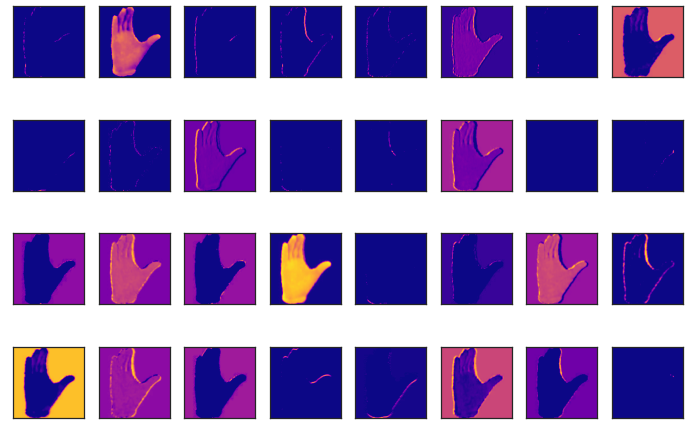

In [57]:
feature_maps = visualization_model.predict(XR)
rows,cols = 4,8
f,ax=plt.subplots(rows,cols,figsize=(rows*3,cols*1))

# plot all 64 maps in an 8x8 squares
ix = 1
for _ in range(cols):
	for _ in range(rows):
		# specify subplot and turn of axis
		ax = pyplot.subplot(rows,cols, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, 2, :,:, ix-1], cmap='plasma')
		ix += 1
# show the figure
pyplot.show()

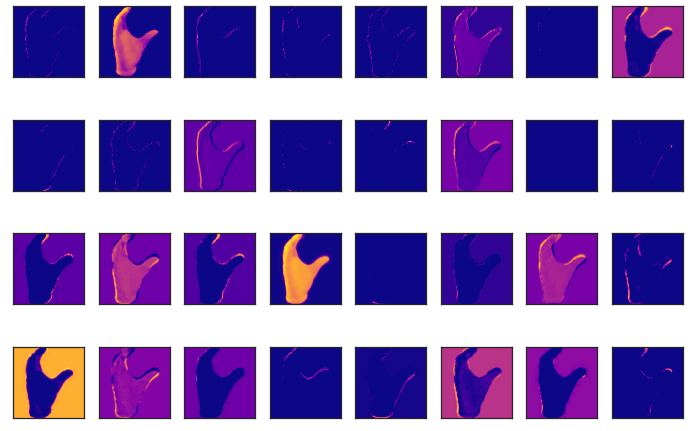

In [58]:
feature_maps = visualization_model.predict(XL)
rows,cols = 4,8
f,ax=plt.subplots(rows,cols,figsize=(rows*3,cols*1))

# plot all 64 maps in an 8x8 squares
ix = 1
for _ in range(cols):
	for _ in range(rows):
		# specify subplot and turn of axis
		ax = pyplot.subplot(rows,cols, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, 2, :,:, ix-1], cmap='plasma')
		ix += 1
# show the figure
pyplot.show()

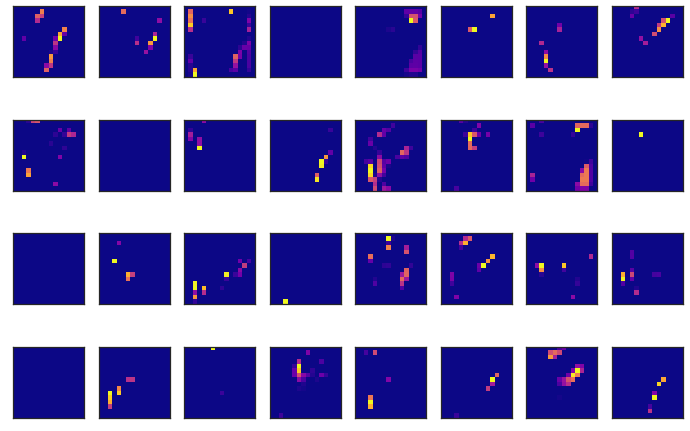

In [63]:
visualization_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[10].output)

feature_maps = visualization_model.predict(XR)
rows,cols = 4,8
f,ax=plt.subplots(rows,cols,figsize=(rows*3,cols*1))

ix = 1
for _ in range(cols):
	for _ in range(rows):
		# specify subplot and turn of axis
		ax = pyplot.subplot(rows,cols, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, 2, :,:, ix-1], cmap='plasma')
		ix += 1
# show the figure
pyplot.show()